# Configs

In [1]:
import random


random.seed(27)

splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Load data

In [ ]:
from utils.prepare_data import getMonitoredPatients
from pandas import Timedelta


patients = getMonitoredPatients()
patients.removePatientAkiEarly(Timedelta(hours=12))

print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

# LSTM

### Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class LSTMModel(nn.Module):
    def __init__(self, inSize):
        super(LSTMModel, self).__init__()

        self.inSize = inSize

        self.lstm = nn.LSTM(
            input_size=inSize, hidden_size=64, batch_first=True, dropout=0.5
        )
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.pool(x.permute(0, 2, 1)).squeeze(2)
        x = F.dropout(x, p=0.5)
        x = self.fc1(x)

        return x

### Train - test function

In [6]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.utils import clip_grad_norm_


def train(
    model,
    device,
    trainLoader,
    valLoader,
    criterion,
    optimizer,
    epochs=20,
    earlyStopping=5,
):
    model.to(device)

    optimScheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3)

    # early stopping
    bestValLoss = float("inf")
    bestModelState = None
    patience = 0

    trainLosses = []
    valLosses = []

    for epoch in range(epochs):
        model.train()
        trainLoss = 0

        for batchX, batchY in trainLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            loss = criterion(outputs, batchY)

            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            trainLoss += loss.item() * batchX.size(0)

        trainLoss /= len(trainLoader.dataset)
        trainLosses.append(trainLoss)

        # validation
        model.eval()
        valLoss = 0

        with torch.no_grad():
            for batchX, batchY in valLoader:
                batchX, batchY = batchX.to(device), batchY.to(device)

                outputs = model(batchX)
                loss = criterion(outputs, batchY)

                valLoss += loss.item() * batchX.size(0)

        valLoss /= len(valLoader.dataset)
        valLosses.append(valLoss)
        
        optimScheduler.step(valLoss)

        if valLoss < bestValLoss:
            bestValLoss = valLoss
            bestModelState = model.state_dict()
            patience = 0
        else:
            patience += 1

        print(
            f"Epoch {epoch+1}/{epochs} Train Loss: {trainLoss:.4f} Val Loss: {valLoss:.4f}"
        )

        if patience > earlyStopping:
            break

    model.load_state_dict(bestModelState)
    return model, trainLosses, valLosses


def predTest(model, device, testLoader):
    model.eval()

    predProbas = []
    actuals = []

    with torch.no_grad():
        for batchX, batchY in testLoader:
            batchX, batchY = batchX.to(device), batchY.to(device)

            outputs = model(batchX)
            probas = torch.sigmoid(outputs)
            predProbas.extend(probas.cpu().numpy())
            actuals.extend(batchY.cpu().numpy())

    return predProbas, actuals

### Train and eval

In [7]:
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
)
from utils.class_voter import combineProbas
from utils.prepare_data import (
    DeepLearningDataPreparer,
    trainValTestPatients,
)
import numpy as np


accuracy_score_list = []
precision_score_list = []
recall_score_list = []
auc_score_list = []
specificity_score_list = []
sensitivity_score_list = []
auc_pr_list = []

train_loss_list = []
val_loss_list = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batchSize = 64

for i, (trainValGenerator, testPatients) in enumerate(
    trainValTestPatients(patients, splitSeed)
):
    models = []
    probas = []
    for ii, (trainPatients, valPatients) in enumerate(trainValGenerator):
        preparer = DeepLearningDataPreparer(
            hoursPerWindows=hoursPerWindow,
            fromHour=0,
            toHour=12,
        )

        (
            (npTrainX, staticTrainX, trainY),
            (npValX, staticValX, valY),
            (npTestX, staticTestX, testY),
        ) = preparer.trainValTest(trainPatients, valPatients, testPatients)

        # neg, pos = np.bincount(trainY)
        # weight0 = (1 / neg) * (len(trainY)) / 2.0
        # weight1 = (1 / pos) * (len(trainY)) / 2.0
        # weight = {0: weight0, 1: weight1}

        # expand static data to be same size as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)
        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)

        # create data loader
        trainLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTrainX).float(),
                torch.tensor(trainY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=True,
        )
        valLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npValX).float(),
                torch.tensor(valY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )
        testLoader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(
                torch.tensor(npTestX).float(),
                torch.tensor(testY).unsqueeze(1).float(),
            ),
            batch_size=batchSize,
            shuffle=False,
        )

        model = LSTMModel(inSize=npTrainX.shape[2])
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

        _, trainLosses, valLosses = train(
            model, device, trainLoader, valLoader, criterion, optimizer, epochs=50, earlyStopping=10,
        )

        models.append(model)
        train_loss_list.append(trainLosses)
        val_loss_list.append(valLosses)

        predProbas, _ = predTest(model, device, testLoader)
        probas.append(predProbas)

    # calculate final probas, auc, accuracy, precision, recal
    finalYProbas = np.apply_along_axis(combineProbas, 0, np.array(probas))
    finalYPred = np.where(finalYProbas > 0.5, 1, 0)
    tn, fp, fn, tp = confusion_matrix(testY, finalYPred).ravel()
    precision_vals, recall_vals, _ = precision_recall_curve(testY, finalYProbas)

    accuracy_score_list.append(accuracy_score(testY, finalYPred))
    specificity_score_list.append(tn / (tn + fp))
    precision_score_list.append(precision_score(testY, finalYPred))
    recall_score_list.append(recall_score(testY, finalYPred))
    auc_score_list.append(roc_auc_score(testY, finalYProbas))
    auc_pr_list.append(auc(recall_vals, precision_vals))

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/50 Train Loss: 0.6808 Val Loss: 0.6730
Epoch 2/50 Train Loss: 0.6423 Val Loss: 0.6436
Epoch 3/50 Train Loss: 0.6059 Val Loss: 0.6164
Epoch 4/50 Train Loss: 0.5715 Val Loss: 0.5984
Epoch 5/50 Train Loss: 0.5328 Val Loss: 0.5768
Epoch 6/50 Train Loss: 0.5089 Val Loss: 0.5703
Epoch 7/50 Train Loss: 0.4965 Val Loss: 0.5704
Epoch 8/50 Train Loss: 0.4878 Val Loss: 0.5601
Epoch 9/50 Train Loss: 0.4798 Val Loss: 0.5531
Epoch 10/50 Train Loss: 0.4825 Val Loss: 0.5660
Epoch 11/50 Train Loss: 0.4687 Val Loss: 0.5735
Epoch 12/50 Train Loss: 0.4612 Val Loss: 0.5549
Epoch 13/50 Train Loss: 0.4622 Val Loss: 0.5533
Epoch 14/50 Train Loss: 0.4611 Val Loss: 0.5609
Epoch 15/50 Train Loss: 0.4565 Val Loss: 0.5688
Epoch 16/50 Train Loss: 0.4532 Val Loss: 0.5662
Epoch 17/50 Train Loss: 0.4511 Val Loss: 0.5707
Epoch 18/50 Train Loss: 0.4506 Val Loss: 0.5699
Epoch 19/50 Train Loss: 0.4517 Val Loss: 0.5645
Epoch 20/50 Train Loss: 0.4527 Val Loss: 0.5605
Epoch 1/50 Train Loss: 0.6956 Val Loss: 0.6873
Ep

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 3/50 Train Loss: 0.6228 Val Loss: 0.6207
Epoch 4/50 Train Loss: 0.5904 Val Loss: 0.5896
Epoch 5/50 Train Loss: 0.5586 Val Loss: 0.5718
Epoch 6/50 Train Loss: 0.5279 Val Loss: 0.5353
Epoch 7/50 Train Loss: 0.5131 Val Loss: 0.5209
Epoch 8/50 Train Loss: 0.5038 Val Loss: 0.5145
Epoch 9/50 Train Loss: 0.4822 Val Loss: 0.5161
Epoch 10/50 Train Loss: 0.4865 Val Loss: 0.5207
Epoch 11/50 Train Loss: 0.4804 Val Loss: 0.5215
Epoch 12/50 Train Loss: 0.4661 Val Loss: 0.5159
Epoch 13/50 Train Loss: 0.4679 Val Loss: 0.5100
Epoch 14/50 Train Loss: 0.4640 Val Loss: 0.5040
Epoch 15/50 Train Loss: 0.4556 Val Loss: 0.5207
Epoch 16/50 Train Loss: 0.4620 Val Loss: 0.5165
Epoch 17/50 Train Loss: 0.4539 Val Loss: 0.5208
Epoch 18/50 Train Loss: 0.4644 Val Loss: 0.5102
Epoch 19/50 Train Loss: 0.4567 Val Loss: 0.5198
Epoch 20/50 Train Loss: 0.4567 Val Loss: 0.5280
Epoch 21/50 Train Loss: 0.4585 Val Loss: 0.5104
Epoch 22/50 Train Loss: 0.4590 Val Loss: 0.5186
Epoch 23/50 Train Loss: 0.4470 Val Loss: 0.5078

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/50 Train Loss: 0.6742 Val Loss: 0.6702
Epoch 2/50 Train Loss: 0.6470 Val Loss: 0.6551
Epoch 3/50 Train Loss: 0.6143 Val Loss: 0.6386
Epoch 4/50 Train Loss: 0.5782 Val Loss: 0.6131
Epoch 5/50 Train Loss: 0.5435 Val Loss: 0.5973
Epoch 6/50 Train Loss: 0.5131 Val Loss: 0.5659
Epoch 7/50 Train Loss: 0.4872 Val Loss: 0.5715
Epoch 8/50 Train Loss: 0.4765 Val Loss: 0.5721
Epoch 9/50 Train Loss: 0.4598 Val Loss: 0.5765
Epoch 10/50 Train Loss: 0.4576 Val Loss: 0.5661
Epoch 11/50 Train Loss: 0.4455 Val Loss: 0.5737
Epoch 12/50 Train Loss: 0.4515 Val Loss: 0.5666
Epoch 13/50 Train Loss: 0.4463 Val Loss: 0.5592
Epoch 14/50 Train Loss: 0.4489 Val Loss: 0.5639
Epoch 15/50 Train Loss: 0.4477 Val Loss: 0.5684
Epoch 16/50 Train Loss: 0.4407 Val Loss: 0.5559
Epoch 17/50 Train Loss: 0.4377 Val Loss: 0.5796
Epoch 18/50 Train Loss: 0.4408 Val Loss: 0.5608
Epoch 19/50 Train Loss: 0.4476 Val Loss: 0.5602
Epoch 20/50 Train Loss: 0.4344 Val Loss: 0.5670
Epoch 21/50 Train Loss: 0.4484 Val Loss: 0.5682
E

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 5/50 Train Loss: 0.5436 Val Loss: 0.5628
Epoch 6/50 Train Loss: 0.5228 Val Loss: 0.5614
Epoch 7/50 Train Loss: 0.5091 Val Loss: 0.5395
Epoch 8/50 Train Loss: 0.4916 Val Loss: 0.5307
Epoch 9/50 Train Loss: 0.4844 Val Loss: 0.5362
Epoch 10/50 Train Loss: 0.4785 Val Loss: 0.5479
Epoch 11/50 Train Loss: 0.4701 Val Loss: 0.5302
Epoch 12/50 Train Loss: 0.4620 Val Loss: 0.5379
Epoch 13/50 Train Loss: 0.4551 Val Loss: 0.5440
Epoch 14/50 Train Loss: 0.4564 Val Loss: 0.5379
Epoch 15/50 Train Loss: 0.4435 Val Loss: 0.5299
Epoch 16/50 Train Loss: 0.4323 Val Loss: 0.5150
Epoch 17/50 Train Loss: 0.4247 Val Loss: 0.5268
Epoch 18/50 Train Loss: 0.4213 Val Loss: 0.5067
Epoch 19/50 Train Loss: 0.4115 Val Loss: 0.5202
Epoch 20/50 Train Loss: 0.4057 Val Loss: 0.5096
Epoch 21/50 Train Loss: 0.3952 Val Loss: 0.5274
Epoch 22/50 Train Loss: 0.3823 Val Loss: 0.5315
Epoch 23/50 Train Loss: 0.3729 Val Loss: 0.5348
Epoch 24/50 Train Loss: 0.3792 Val Loss: 0.5124
Epoch 25/50 Train Loss: 0.3718 Val Loss: 0.53

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 1/50 Train Loss: 0.6779 Val Loss: 0.6742
Epoch 2/50 Train Loss: 0.6436 Val Loss: 0.6517
Epoch 3/50 Train Loss: 0.6031 Val Loss: 0.6251
Epoch 4/50 Train Loss: 0.5694 Val Loss: 0.6017
Epoch 5/50 Train Loss: 0.5352 Val Loss: 0.5664
Epoch 6/50 Train Loss: 0.5172 Val Loss: 0.5586
Epoch 7/50 Train Loss: 0.5024 Val Loss: 0.5525
Epoch 8/50 Train Loss: 0.4902 Val Loss: 0.5338
Epoch 9/50 Train Loss: 0.4914 Val Loss: 0.5498
Epoch 10/50 Train Loss: 0.4807 Val Loss: 0.5508
Epoch 11/50 Train Loss: 0.4675 Val Loss: 0.5453
Epoch 12/50 Train Loss: 0.4667 Val Loss: 0.5560
Epoch 13/50 Train Loss: 0.4618 Val Loss: 0.5505
Epoch 14/50 Train Loss: 0.4589 Val Loss: 0.5404
Epoch 15/50 Train Loss: 0.4561 Val Loss: 0.5457
Epoch 16/50 Train Loss: 0.4497 Val Loss: 0.5536
Epoch 17/50 Train Loss: 0.4443 Val Loss: 0.5536
Epoch 18/50 Train Loss: 0.4510 Val Loss: 0.5392
Epoch 19/50 Train Loss: 0.4476 Val Loss: 0.5518
Epoch 1/50 Train Loss: 0.6692 Val Loss: 0.6603
Epoch 2/50 Train Loss: 0.6363 Val Loss: 0.6316
Epo

/media/data3/users/tubh/micromamba/envs/dka-aki/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Epoch 2/50 Train Loss: 0.6315 Val Loss: 0.6277
Epoch 3/50 Train Loss: 0.6023 Val Loss: 0.6102
Epoch 4/50 Train Loss: 0.5618 Val Loss: 0.5818
Epoch 5/50 Train Loss: 0.5379 Val Loss: 0.5519
Epoch 6/50 Train Loss: 0.5111 Val Loss: 0.5377
Epoch 7/50 Train Loss: 0.4945 Val Loss: 0.5357
Epoch 8/50 Train Loss: 0.4833 Val Loss: 0.5330
Epoch 9/50 Train Loss: 0.4769 Val Loss: 0.5361
Epoch 10/50 Train Loss: 0.4710 Val Loss: 0.5161
Epoch 11/50 Train Loss: 0.4647 Val Loss: 0.5242
Epoch 12/50 Train Loss: 0.4523 Val Loss: 0.5396
Epoch 13/50 Train Loss: 0.4453 Val Loss: 0.5194
Epoch 14/50 Train Loss: 0.4360 Val Loss: 0.5149
Epoch 15/50 Train Loss: 0.4413 Val Loss: 0.5267
Epoch 16/50 Train Loss: 0.4274 Val Loss: 0.5243
Epoch 17/50 Train Loss: 0.4197 Val Loss: 0.5394
Epoch 18/50 Train Loss: 0.4103 Val Loss: 0.5279
Epoch 19/50 Train Loss: 0.4035 Val Loss: 0.5216
Epoch 20/50 Train Loss: 0.4100 Val Loss: 0.5280
Epoch 21/50 Train Loss: 0.4056 Val Loss: 0.5363
Epoch 22/50 Train Loss: 0.4064 Val Loss: 0.5274


In [8]:
print(f"AUC: {np.mean(auc_score_list)} +- {np.std(auc_score_list)}", auc_score_list)
print(f"Accuracy: {np.mean(accuracy_score_list)} +- {np.std(accuracy_score_list)}", accuracy_score_list)
print(f"Specificity: {np.mean(specificity_score_list)} +- {np.std(specificity_score_list)}", specificity_score_list)
print(f"Precision: {np.mean(precision_score_list)} +- {np.std(precision_score_list)}", precision_score_list)
print(f"Recall: {np.mean(recall_score_list)} +- {np.std(recall_score_list)}", recall_score_list)
print(f"AUC PR: {np.mean(auc_pr_list)} +- {np.std(auc_pr_list)}", auc_pr_list)

AUC: 0.8165904860385774 +- 0.018407365202436708 [np.float64(0.8236525379382523), np.float64(0.7991452991452991), np.float64(0.8350962372117219), np.float64(0.8344893358765391), np.float64(0.7905690200210749)]
Accuracy: 0.7544087301587302 +- 0.028148099539481445 [0.7688888888888888, 0.7333333333333333, 0.7822222222222223, 0.7777777777777778, 0.7098214285714286]
Specificity: 0.79233063088249 +- 0.03267651467902791 [np.float64(0.8163265306122449), np.float64(0.782312925170068), np.float64(0.821917808219178), np.float64(0.8082191780821918), np.float64(0.7328767123287672)]
Precision: 0.6394399467103915 +- 0.042189498603489486 [0.6625, 0.6097560975609756, 0.6829268292682927, 0.6705882352941176, 0.5714285714285714]
Recall: 0.6835118468029859 +- 0.02895564134574771 [0.6794871794871795, 0.6410256410256411, 0.7088607594936709, 0.7215189873417721, 0.6666666666666666]
AUC PR: 0.7114106755417703 +- 0.025132181697918105 [np.float64(0.70679456500484), np.float64(0.7029036368776637), np.float64(0.7192

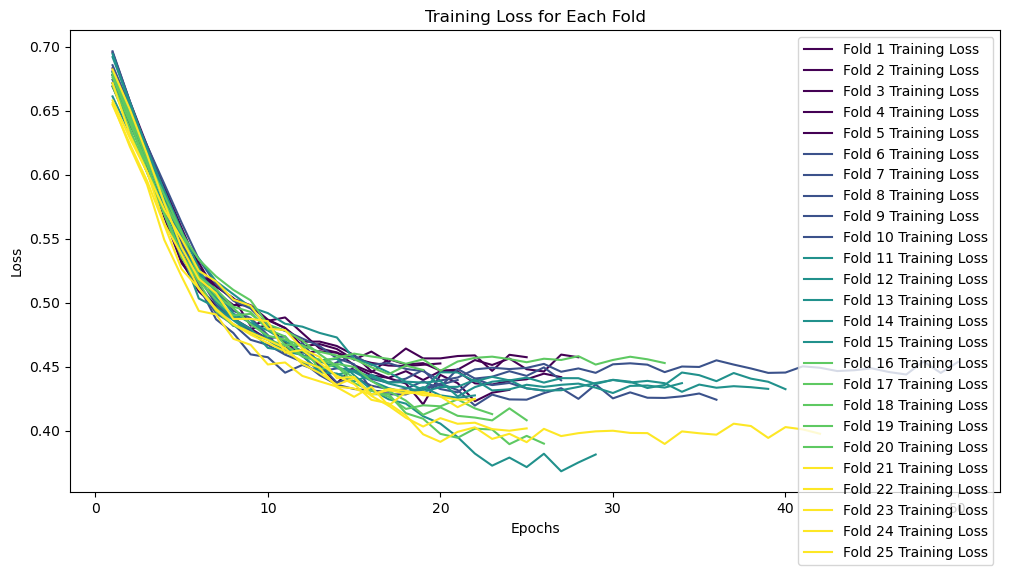

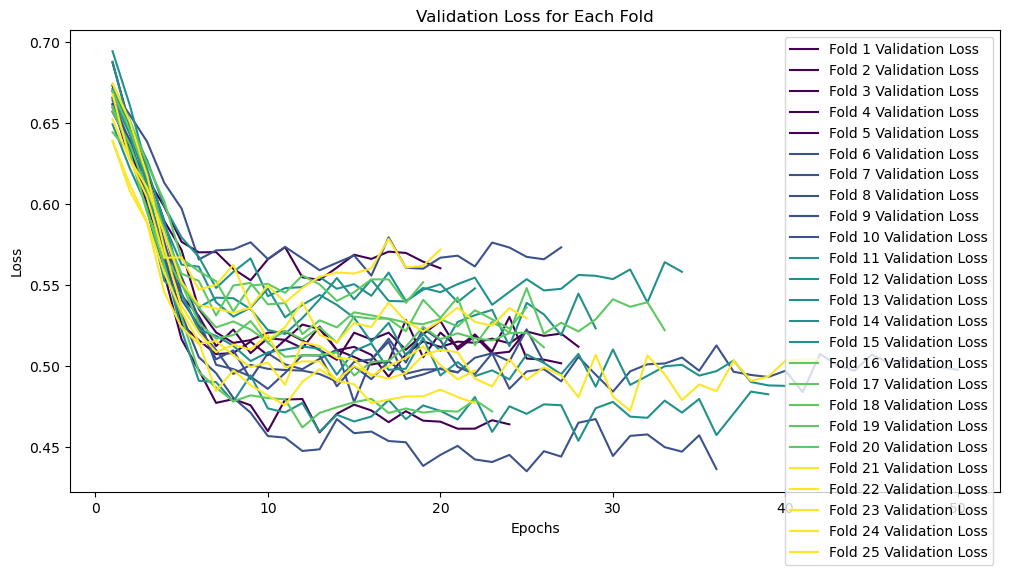

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


plt.figure(figsize=(12, 6))
colors = cm.viridis(np.linspace(0, 1, 5))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1),
        train_loss,
        label=f"Fold {i+1} Training Loss",
        color=colors[i // 5],
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(
        range(1, len(val_loss) + 1),
        val_loss,
        label=f"Fold {i+1} Validation Loss",
        color=colors[i // 5],
    )
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/lstm_only_val_loss.svg")
plt.show()